## Melting temperature workflow

- ~~Macro for free energy calculation~~
- ~~Get a simple while loop for FE working~~
- ~~Do TS runs instead of FE runs in while loop, terminate after #iterations~~
- Do solid calculations in loop, stop if melted, change temp range
- Add liquid to the mix, stop if frozen, change temp range
- Add node for initial guess
- Check Tm exists, stop if found, else change temp range by extrapolation
- Test the routine

In [1]:
from pyiron_workflow import Workflow
import numpy as np
import matplotlib.pyplot as plt
import pyiron_workflow as pwf
from typing import Union

In [2]:
from calphy_nodes import RunTSSolidMacro, RunTSLiquidMacro, InputClass

In [9]:
@Workflow.wrap.as_function_node
def analyse_fe():
    pass

@Workflow.wrap.as_function_node
def update_trange(temperature, increment, error_status):
    if error_status == 'melted':
        new_temperature = []
        new_temperature.append(temperature[0]-increment)
        new_temperature.append(temperature[1]-increment)
    elif error_status == 'solidified':
        new_temperature = []
        new_temperature.append(temperature[0]+increment)
        new_temperature.append(temperature[1]+increment)
    else:
        new_temperature = []
        new_temperature.append(temperature[0])
        new_temperature.append(temperature[1])
    return new_temperature

@Workflow.wrap.as_function_node
def get_trange(temperature, increment):
    new_temperature = []
    new_temperature.append(temperature-increment)
    new_temperature.append(temperature-increment)
    return new_temperature

@Workflow.wrap.as_function_node
def increment_iteration(iteration):
    new_iteration = iteration + 1
    return new_iteration

@Workflow.wrap.as_function_node
def condition(iteration, maxiteration, found):
    finished = True
    if iteration < maxiteration:
        finished = False
    if found:
        finished = True
    return finished

@Workflow.wrap.as_function_node
def guess_tm(species):
    import mendeleev
    chem = mendeleev.element(species)
    melting_temperature = chem.melting_point
    return melting_temperature


In [ ]:
@Workflow.wrap.as_macro_node
def WhileRunFreeEnergySolid(wf, inp,
                       species: str, 
                       potential: str,
                       temperature: Union[float, list[float]],
                       increment: float,
                       max_iteration: int = 3,
                       iteration: int = 0):
    #Run solid calculation
    wf.free_energy = RunTSSolidMacro(inp,
                                  species,
                                  potential,
                                  wf.temp_range.new_temperature)
    
    #update trange based on the error
    wf.update_trange = update_trange(wf.temp_range.new_temperature, increment, 
                                    wf.free_energy.output.error_status)
    

In [4]:
@Workflow.wrap.as_macro_node('output_fe')
def WhileRunFreeEnergy(wf, inp, 
                       species: str, 
                       potential: str,
                       temperature: Union[float, list[float]],
                       increment: float,
                       max_iteration: int = 3,
                       iteration: int = 0):
    #guess Tm
    wf.tm = guess_tm(species)
    #get initial temperature range
    wf.temp_range = get_trange(wf.tm.melting_temperature, increment)
    #Run solid calculation
    wf.free_energy = RunTSSolidMacro(inp,
                                  species,
                                  potential,
                                  wf.temp_range.new_temperature)
    
    #update trange based on the error
    wf.update_trange = update_trange(wf.temp_range.new_temperature, increment, 
                                    wf.free_energy.output.error_status)
    
    
    wf.increment_iteration = increment_iteration(iteration)
    wf.increment_iteration.inputs.iteration = wf.increment_iteration.outputs.new_iteration
    wf.free_energy.inputs.temperature = wf.increment_temperature.outputs.new_temperature
    wf.condition = condition(wf.increment_iteration.outputs.new_iteration, 
                                               max_iteration, False)
    
    wf.switch = pwf.standard_nodes.If()
    wf.switch.inputs.condition = wf.condition
    
    wf.starting_nodes = [wf.free_energy]
    wf.free_energy >> wf.increment_temperature >> wf.increment_iteration >> wf.condition >> wf.switch
    wf.switch.signals.output.true >> wf.free_energy
    return wf.free_energy.outputs.error_status

In [5]:
inp = InputClass(temperature=[800, 900],
                pressure=0,
                reference_phase = 'solid',
                mode = 'ts',
                equilibration_control = 'berendsen',
                )
inp.queue.cores = 4	

In [6]:
macro = WhileRunFreeEnergy(inp,
                          'Cu',
                          '2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2',
                           [800, 900],
                           100.,
                          )

In [7]:
macro.run()

/cmmc/ptmp/pyironhb/mambaforge/envs/pyiron_mpie_cmti_2024-09-09/lib/python3.11/site-packages/ase/io/lammpsdata.py:49: FutureWarning: "style" is deprecated; please use "atom_style".
  warnings.warn(
--------------------------------------------------------------------------

  Local host:   cmti001
  Local device: hfi1_0
--------------------------------------------------------------------------
--------------------------------------------------------------------------

  Local host:   cmti001
  Local device: hfi1_0
--------------------------------------------------------------------------
--------------------------------------------------------------------------

  Local host:   cmti001
  Local device: hfi1_0
--------------------------------------------------------------------------
--------------------------------------------------------------------------

  Local host:   cmti001
  Local device: hfi1_0
--------------------------------------------------------------------------
----------

{'output_fe': None}

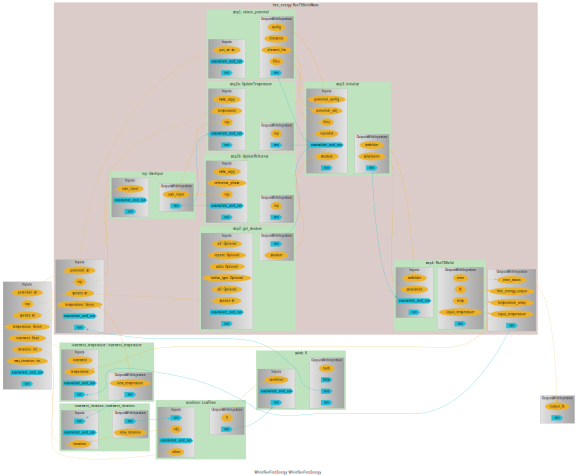

In [8]:
macro.draw(size=(8,8), depth=2)